# HW 1, Two-dimensional data

In [1]:
import os

import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt

PATH_DATA = os.path.join('data', 'distribution.npy')

Прочитаем данные. Там дано двухмерное распределение плотности вероятности. И нарисуем его.

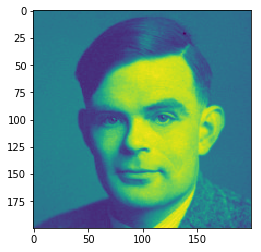

In [2]:
xs_all = np.load(PATH_DATA)

plt.imshow(xs_all)
plt.show()

Но нам нужен датасет. Поэтому воспользуемся данным распределением для сэмплирования датасета.

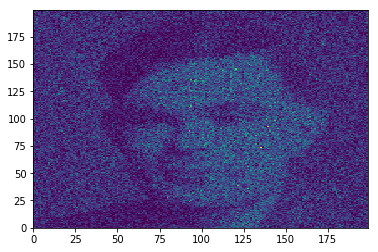

In [3]:
n = 100000
n_train = int(n * 0.8)
samples = np.random.choice(xs_all.size, p=xs_all.reshape(-1), size=n)
x = samples % 200
y = samples // 200
samples = np.stack([x, y], axis=1)
xs_train, xs_val = samples[:n_train], samples[n_train:]

plt.hist2d(x, 199 - y, bins=200)
plt.show()

Теперь сделаем загрузчик данных

In [4]:
batch_size = 100

def collate_fn(xs):
    xs = torch.LongTensor(xs)
    xs_one_hot = F.one_hot(xs, 200).float()
    return xs_one_hot

train_data_loader = data.DataLoader(
    dataset=xs_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
val_data_loader = data.DataLoader(
    dataset=xs_val,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

## 2.1 Не MADE

Нам понадобиться модель распределения априорной вероятности из первого задания.

In [5]:
class ApriorProb(nn.Module):
    def __init__(self, size):
        super(ApriorProb, self).__init__()
        
        self.theta = nn.Parameter(torch.zeros(size))
        self.softmax = nn.Softmax(dim=0)

    def forward(self):
        x = self.theta
        x = self.softmax(x)
        return x

А также сеть для нахождения условной вероятности.

Стоит отметить, что так как на вход подаются one-hot векторы, первый полносвязный слой стоит проинициализировать обычным нормальным распределением, так как его веса по суте являются эмбеддингами, вместо распределения, сохраняющего дисперсию.

In [6]:
class MLP(nn.Module):
    def __init__(self, size, n_hidden_layers=2, dropaut_p=0.8):
        super(MLP, self).__init__()
        
        layers = []
        for _ in range(n_hidden_layers):
            layers += [
                nn.Linear(size, size, bias=False),
                nn.ReLU(),
                nn.Dropout(p=dropaut_p)
            ]
        layers += [
            nn.Linear(size, size, bias=False),
            nn.Softmax(dim=1)
        ]
        torch.nn.init.normal_(layers[0].weight)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.model(x)
        return x

Соберем все вместе

In [7]:
class ModelMLP(nn.Module):
    def __init__(self, size, n_hidden_layers=2, dropaut_p=0.8):
        super(ModelMLP, self).__init__()
        
        self.size = size
        self.apr_p = ApriorProb(self.size)
        self.cond_p = MLP(self.size, n_hidden_layers, dropaut_p)

    def forward(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        
        p_x1 = self.apr_p()
        p_x1 = torch.stack([p_x1] * x1.size(0), 0)
        p_x1 = (p_x1 * x1).sum(dim=1)
        
        p_x2 = self.cond_p(x1)
        p_x2 = (p_x2 * x2).sum(dim=1)
        
        p = p_x1 * p_x2
        return p

В качестве ошибки возьмем логарифмическую функцию правдоподобия

In [8]:
class MLLELoss(nn.Module):
    eps = 1e-9
    
    def __init__(self):
        super(MLLELoss, self).__init__()

    def forward(self, ps):
        loss = -torch.log(ps + MLLELoss.eps)
        loss = loss.mean()
        return loss

Функция обучения

In [9]:
def train(model, criterion, optimizer, epochs):
    losses_train = []
    losses_val = []
    for i in tqdm(range(epochs)):
        losses = []
        model.train()
        for xs in train_data_loader:
            optimizer.zero_grad()

            ps = model(xs)
            loss = criterion(ps)

            losses.append(loss.item())

            loss.backward()
            optimizer.step()

        losses_train.append(np.array(losses).mean())

        losses = []
        model.eval()
        with torch.no_grad():
            for xs in val_data_loader:
                ps = model(xs)
                loss = criterion(ps)

                losses.append(loss.item())

        losses_val.append(np.array(losses).mean())

    plt.plot(range(epochs), losses_train, label="train")
    plt.plot(range(epochs), losses_val, label="val")
    plt.xlabel('epoch num')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

И функция для отображения выученного распределения

In [10]:
def draw_model_hist(model):
    xs = np.stack([
        np.repeat(np.arange(200), 200),
        np.stack([np.arange(200)] * 200).reshape(-1)
    ]).transpose()
    with torch.no_grad():
        xs = collate_fn(xs)
        ps = model(xs).reshape(200 ** 2, -1)
        ps = ps.prod(dim=-1)
        ps = ps.numpy().reshape(200, 200).transpose()
                
    plt.imshow(ps)
    plt.show()

Обучаем модель

100%|██████████| 10/10 [00:20<00:00,  1.94s/it]


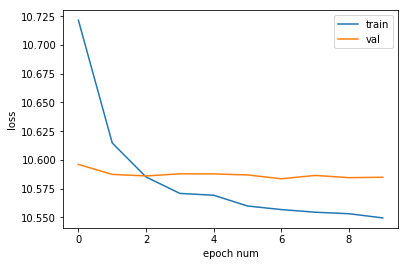

In [11]:
epochs = 10
lr = 0.001
w_l2 = 0

model = ModelMLP(200, n_hidden_layers=1, dropaut_p=0.6)

criterion = MLLELoss()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)

train(model, criterion, optimizer, epochs)

Нарисуем, что получилось

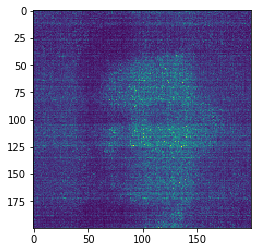

In [12]:
model.eval()
draw_model_hist(model)

## 2.2 MADE

Нам нужно маскировать полносвязные слои. Напишем для таких слоев специальный класс.

In [13]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, ms=None):
        super().__init__(in_features, out_features, bias)
        
        if not ms:
            mask = np.ones((out_features, in_features))
        else:
            m1, m2 = ms
            mask = m2.reshape(-1, 1) >= m1.reshape(1, -1)
        
        mask = mask.astype(np.float32)
        self.register_buffer('mask', torch.tensor(mask))
        
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedLinear, self).forward(x)

И собственно MADE, который принимает one-hot векторы, а возвращает вероятности для всех элементов.

In [14]:
class MADE(nn.Module):
    def __init__(self, d=2, n_classes=200, hidden_size=200, n_hidden_layers=1):
        super(MADE, self).__init__()
        
        self.d = d
        self.n_classes = n_classes
        input_size = self.d * self.n_classes
        
        m = [np.repeat(np.arange(self.d), self.n_classes) + 1]
        for i in range(n_hidden_layers):
            m += [np.random.randint(m[-1].min(), d, size=hidden_size)]
        
        layers = [
            MaskedLinear(input_size, hidden_size, ms=m[0:2]),
            nn.ReLU()
        ]
        for i in np.arange(1, n_hidden_layers):
            layers += [
                MaskedLinear(hidden_size, hidden_size, ms=m[i:i + 2]),
                nn.ReLU()
            ]
        
        layers += [
            MaskedLinear(hidden_size, input_size, ms=(m[-1], m[0]))
        ]
        self.layers = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        x_in = x
        
        x = x.view(-1, self.d * self.n_classes)
        x = self.layers(x)
        x = x.view(-1, self.d, self.n_classes)
        x = self.softmax(x)
        
        x = (x * x_in).sum(dim=2)
        return x

Обучим

100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


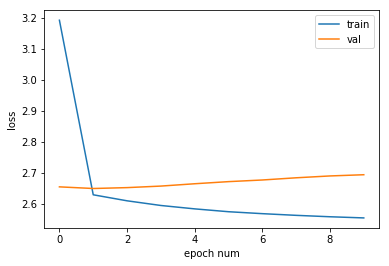

In [15]:
epochs = 10
lr = 0.001
w_l2 = 0

model = MADE(d=2, n_classes=200, hidden_size=200, n_hidden_layers=1)

criterion = MLLELoss()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)

train(model, criterion, optimizer, epochs)

И нарисуем

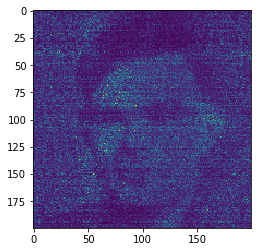

In [16]:
model.eval()
draw_model_hist(model)